# Train Stats

```
 ----------------------------------------------------------------------------------------
/                                                                                        \
| /$$$$$$$$                 /$$            /$$$$$$   /$$                 /$$             |
||__  $$__/                |__/           /$$__  $$ | $$                | $$             |
|   | $$  /$$$$$$  /$$$$$$  /$$ /$$$$$$$ | $$  \__//$$$$$$    /$$$$$$  /$$$$$$   /$$$$$$$|
|   | $$ /$$__  $$|____  $$| $$| $$__  $$|  $$$$$$|_  $$_/   |____  $$|_  $$_/  /$$_____/|
|   | $$| $$  \__/ /$$$$$$$| $$| $$  \ $$ \____  $$ | $$      /$$$$$$$  | $$   |  $$$$$$ |
|   | $$| $$      /$$__  $$| $$| $$  | $$ /$$  \ $$ | $$ /$$ /$$__  $$  | $$ /$$\____  $$|
|   | $$| $$     |  $$$$$$$| $$| $$  | $$|  $$$$$$/ |  $$$$/|  $$$$$$$  |  $$$$//$$$$$$$/|
|   |__/|__/      \_______/|__/|__/  |__/ \______/   \___/   \_______/   \___/ |_______/ |
|                                                                                        |
|                                                                                        |
|                                                                                        |
|                                      🚂 ¯\_(ツ)_/¯?                                     |
\                                                                                        /
 ----------------------------------------------------------------------------------------
    \     
     \     
      \      
           ___ ____
         ⎛   ⎛ ,----
          \  //==--'
     _//|,.·//==--'    ____________________________
    _OO≣=-  ︶ ᴹw ⎞_§ ______  ___\ ___\ ,\__ \/ __ \
   (∞)_, )  (     |  ______/__  \/ /__ / /_/ / /_/ /
     ¨--¨|| |- (  / ______\____/ \___/ \__^_/  .__/
         ««_/  «_/ jgs/bd808                /_/
```

In which I look at data from the past several hundred trains and pretend that I know how to do exploratory data analysis.

In [40]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
    
engine = create_engine('sqlite:///data/train.db')
df = pd.read_sql('''
SELECT
    version,
    rollbacks,
    rollbacks_time,
    group2_delay_days,
    (group0_delay_days +
     group1_delay_days +
     group2_delay_days) as total_delay,
    total_time as train_total_time,
    (select count(*) from blocker b where b.train_id = t.id) as blockers,
    (select count(*) from blocker b where b.train_id = t.id and resolved = 1) as resolved_blockers,
    patches,
    (select max(time_in_review) from patch p where p.train_id = t.id) as max_time_in_review,
    (select max(comments) from patch where patch.train_id = t.id) as max_comments_per_patch,
    (select max(start_time - created) from patch p where p.train_id = t.id) as max_cycle_time
FROM train t
''', engine)

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')
df.head()

,version,rollbacks,rollbacks_time,group2_delay_days,total_delay,train_total_time,blockers,resolved_blockers,patches,max_time_in_review,max_comments_per_patch,max_cycle_time
0,1.37.0-wmf.1,0,0,0,0,178349,5,3,450,36809044.0,27.0,36952873.0
1,1.37.0-wmf.3,3,94493,0,1,219880,7,6,366,56122286.0,30.0,56562620.0
2,1.37.0-wmf.4,1,66812,1,3,263742,9,4,422,38820872.0,29.0,38982601.0
3,1.36.0-wmf.1,0,0,4,4,519622,1,1,566,47181045.0,31.0,47755190.0
4,1.36.0-wmf.2,4,389769,4,5,554704,7,1,273,110996452.0,33.0,111569626.0


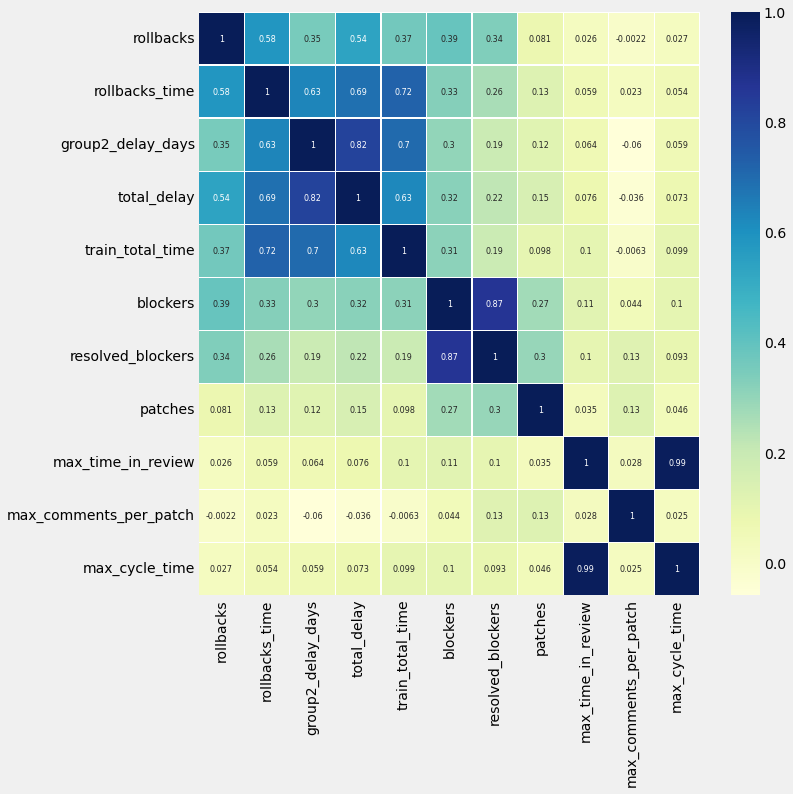

In [41]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Text(0.5, 1.02, 'Blockers per Train')

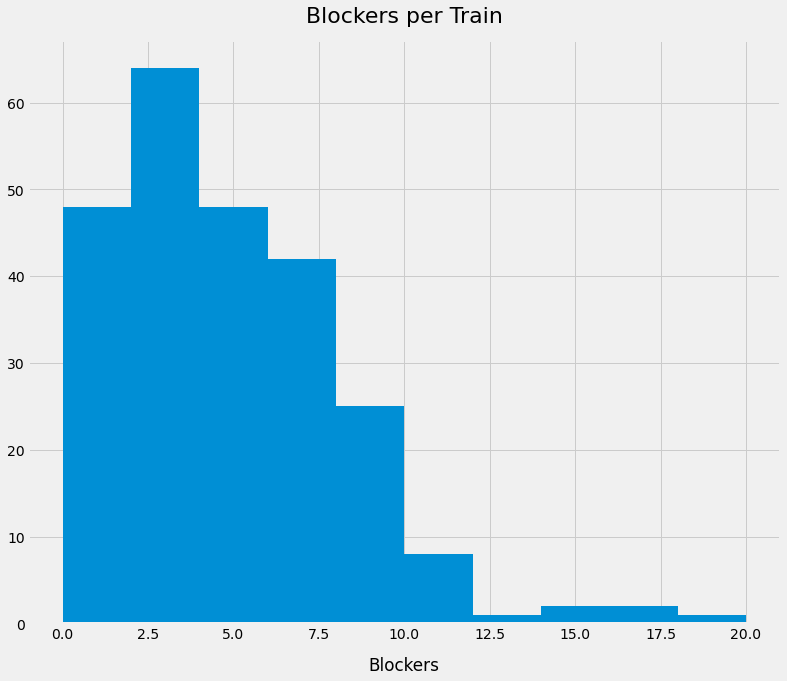

In [42]:
df.set_index('version')['blockers'].hist(figsize=(12, 10))
plt.xlabel("Blockers", labelpad=15)
plt.title("Blockers per Train", y=1.02, fontsize=22)

In [43]:
df[df['blockers'] > 10].sort_values(by='blockers', ascending=False)

,version,rollbacks,rollbacks_time,group2_delay_days,total_delay,train_total_time,blockers,resolved_blockers,patches,max_time_in_review,max_comments_per_patch,max_cycle_time
82,1.34.0-wmf.20,1,16897,5,5,600096,20,11,413,60583935.0,37.0,60715205.0
103,1.33.0-wmf.22,0,0,0,1,63844,17,11,391,107411197.0,45.0,107659715.0
77,1.34.0-wmf.14,2,412678,4,5,524983,16,7,646,73502579.0,34.0,73539481.0
136,1.31.0-wmf.20,2,134534,1,5,255075,14,12,822,66099647.0,75.0,67210868.0
210,1.30.0-wmf.2,2,595079,0,0,782668,14,12,462,67958577.0,56.0,68943029.0
124,1.32.0-wmf.22,0,0,0,0,173055,12,7,824,64869761.0,44.0,65392036.0
57,1.35.0-wmf.31,3,365118,4,15,516489,11,7,427,72215548.0,70.0,72206585.0
76,1.34.0-wmf.13,2,14912,0,1,183853,11,8,471,53208155.0,23.0,53820019.0
187,1.28.0-wmf.21,1,88476,0,1,176082,11,8,514,60386455.0,93.0,61360331.0


In [44]:
block_df = pd.read_sql('''
SELECT
    version,
    group_blocked
FROM train t
JOIN blocker b ON t.id = b.train_id
''', engine)
block_df.head()

,version,group_blocked
0,1.37.0-wmf.7,-1
1,1.37.0-wmf.7,-1
2,1.37.0-wmf.12,2
3,1.37.0-wmf.12,1
4,1.37.0-wmf.12,1


In [45]:
block_df.group_blocked.unique()

array([-1,  2,  1,  0])

In [46]:
group_name_map = {
    -1: "Earlier",
    0: "Group0",
    1: "Group1",
    2: "Group2",
}
block_df['blocker_added'] = block_df.group_blocked.map(group_name_map)
block_df.head()

,version,group_blocked,blocker_added
0,1.37.0-wmf.7,-1,Earlier
1,1.37.0-wmf.7,-1,Earlier
2,1.37.0-wmf.12,2,Group2
3,1.37.0-wmf.12,1,Group1
4,1.37.0-wmf.12,1,Group1


In [47]:
block_df.group_blocked.value_counts()

-1    358
 1    330
 0    262
 2    120
Name: group_blocked, dtype: int64

In [48]:
block_df.version

0        1.37.0-wmf.7
1        1.37.0-wmf.7
2       1.37.0-wmf.12
3       1.37.0-wmf.12
4       1.37.0-wmf.12
            ...      
1065    1.38.0-wmf.17
1066    1.38.0-wmf.17
1067    1.38.0-wmf.17
1068    1.38.0-wmf.17
1069    1.38.0-wmf.17
Name: version, Length: 1070, dtype: object

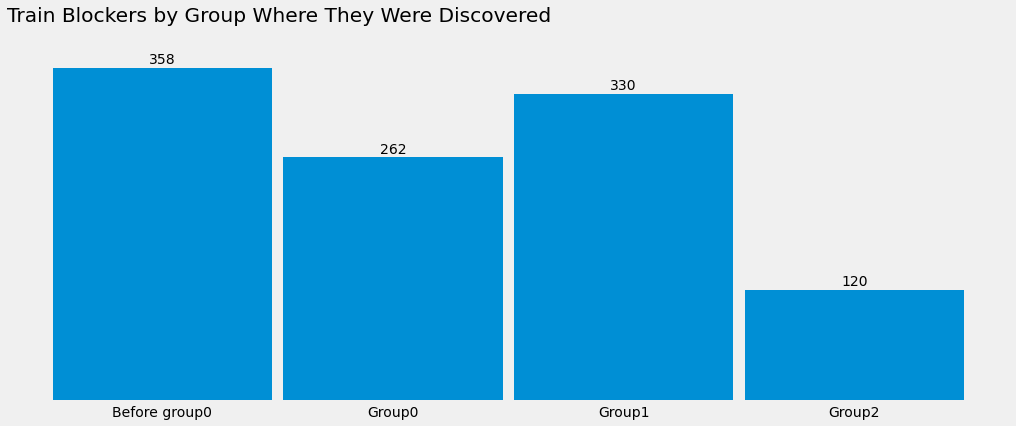

In [49]:
block_df.set_index('version')
block_df.sort_values('group_blocked', inplace=True)


fig = plt.figure(figsize=(16,6))
plt.grid(color='white', lw=0.5, axis='x')
n, bins, patches = plt.hist(block_df.blocker_added, bins=4, rwidth=0.95)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
xticks_labels = [ "{:.2f}\nto\n{:.2f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels=["Before group0", "Group0", "Group1", "Group2"])

# remove y ticks
plt.yticks([])

# plot values on top of bars
for idx, value in enumerate(n):
    if value > 0:
        plt.text(xticks[idx], value+5, int(value), ha='center')

plt.title('Train Blockers by Group Where They Were Discovered', loc='left', pad=30)
plt.show()


In [50]:
patches = pd.read_sql('''
SELECT
    link,
    version,
    submitted,
    insertions as ins,
    (deletions*-1) as del
FROM patch p JOIN train t ON t.id = p.train_id
''', engine)
patches.describe()

,submitted,ins,del
count,8.292200e+04,8.292200e+04,8.292200e+04
mean,1.554097e+09,3.635055e+02,-2.885064e+02
std,4.962027e+07,6.026103e+04,5.777254e+04
min,1.431572e+09,0.000000e+00,-1.661412e+07
25%,1.518027e+09,2.000000e+00,-1.600000e+01
50%,1.558310e+09,6.000000e+00,-4.000000e+00
75%,1.592501e+09,3.000000e+01,-1.000000e+00
max,1.641893e+09,1.728860e+07,0.000000e+00


In [51]:
patches['loc'] = patches['ins'] + patches['del']
patches.head()

,link,version,submitted,ins,del,loc
0,"https://gerrit.wikimedia.org/r/#/q/ccbfcf28,n,z",1.37.0-wmf.1,1618945759,5,-1,4
1,"https://gerrit.wikimedia.org/r/#/q/3302274f,n,z",1.37.0-wmf.1,1618878371,1156,-660,496
2,"https://gerrit.wikimedia.org/r/#/q/8b5471b5,n,z",1.37.0-wmf.1,1618343309,976,-3,973
3,"https://gerrit.wikimedia.org/r/#/q/a6abbb67,n,z",1.37.0-wmf.1,1618341075,8,-29,-21
4,"https://gerrit.wikimedia.org/r/#/q/af916aad,n,z",1.37.0-wmf.1,1618300868,7,-5,2


In [52]:
patches['submitted'] = pd.to_datetime(patches['submitted'], unit='s')
patches.set_index('submitted', inplace=True)

In [53]:
out = patches.groupby(pd.Grouper(freq='M')).apply(lambda x: x)
out = out[out['link'] != 'https://gerrit.wikimedia.org/r/#/q/9a08dbab,n,z'] # The one patch that inserts 17.2M lines of code
out['ok'] = out['loc'].cumsum()

## Cycle time/Lead time

**Cycle time** is the time from when a patch enters code review to the time that it's in production. **Lead time** is the time it takes from commit to production.

In [54]:
# GOAL
#         train     lead_time    cycle_time   Id
# 0    1.37.0-wmf.6    200   2000   u1234
# 1    1.37.0-wmf.6    123   2800   u1235

cycle = pd.read_sql('''
SELECT
    substr(version, 8) as version,
    datetime(start_time, 'unixepoch'),
    (start_time - created) as cycle_time,
    (start_time - submitted) as lead_time,
    datetime(created, 'unixepoch'),
    datetime(submitted, 'unixepoch'),
    link
FROM patch p JOIN train t ON t.id = p.train_id
WHERE (lead_time > 0 AND cycle_time > 0)
    AND (
        version = '1.38.0-wmf.13' OR
        version = '1.38.0-wmf.16' OR
        version = '1.38.0-wmf.17'
    )
''', engine)
cycle.head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link
0,wmf.13,2021-12-14 20:14:15,40034,38829,2021-12-14 09:07:01,2021-12-14 09:27:06,https://gerrit.wikimedia.org/r/q/746984
1,wmf.13,2021-12-14 20:14:15,20253948,48599,2021-04-24 10:08:27,2021-12-14 06:44:16,https://gerrit.wikimedia.org/r/q/682214
2,wmf.13,2021-12-14 20:14:15,361079,52844,2021-12-10 15:56:16,2021-12-14 05:33:31,https://gerrit.wikimedia.org/r/q/745752
3,wmf.13,2021-12-14 20:14:15,71920339,60054,2019-09-04 10:21:56,2021-12-14 03:33:21,https://gerrit.wikimedia.org/r/q/534268
4,wmf.13,2021-12-14 20:14:15,906458,70816,2021-12-04 08:26:37,2021-12-14 00:33:59,https://gerrit.wikimedia.org/r/q/743516


In [55]:
cycle.sort_values(by='lead_time', ascending=False).head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link
90,wmf.13,2021-12-14 20:14:15,664488,635655,2021-12-07 03:39:27,2021-12-07 11:40:00,https://gerrit.wikimedia.org/r/q/744093
352,wmf.17,2022-01-11 19:20:15,1714374,630359,2021-12-22 23:07:21,2022-01-04 12:14:16,https://gerrit.wikimedia.org/r/q/749551
473,wmf.17,2022-01-11 19:20:15,742085,630354,2022-01-03 05:12:10,2022-01-04 12:14:21,https://gerrit.wikimedia.org/r/q/750803
215,wmf.13,2021-12-14 20:14:15,1245088,630013,2021-11-30 10:22:47,2021-12-07 13:14:02,https://gerrit.wikimedia.org/r/q/742586
157,wmf.13,2021-12-14 20:14:15,630767,630011,2021-12-07 13:01:28,2021-12-07 13:14:04,https://gerrit.wikimedia.org/r/q/744669


### Lead time

The time from commit to deploy (in seconds)

In [56]:
cycle['lead_time_days'] = cycle['lead_time'] / (60*60*24)
cycle['cycle_time_days'] = cycle['cycle_time'] / (60*60*24)
cycle.sort_values(by='lead_time_days').head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link,lead_time_days,cycle_time_days
297,wmf.17,2022-01-11 19:20:15,36799,35704,2022-01-11 09:06:56,2022-01-11 09:25:11,https://gerrit.wikimedia.org/r/q/752802,0.413241,0.425914
0,wmf.13,2021-12-14 20:14:15,40034,38829,2021-12-14 09:07:01,2021-12-14 09:27:06,https://gerrit.wikimedia.org/r/q/746984,0.449410,0.463356
464,wmf.17,2022-01-11 19:20:15,42952,39735,2022-01-11 07:24:23,2022-01-11 08:18:00,https://gerrit.wikimedia.org/r/q/752787,0.459896,0.497130
565,wmf.17,2022-01-11 19:20:15,61597,40719,2022-01-11 02:13:38,2022-01-11 08:01:36,https://gerrit.wikimedia.org/r/q/752723,0.471285,0.712928
486,wmf.17,2022-01-11 19:20:15,311344,40721,2022-01-08 04:51:11,2022-01-11 08:01:34,https://gerrit.wikimedia.org/r/q/752220,0.471308,3.603519


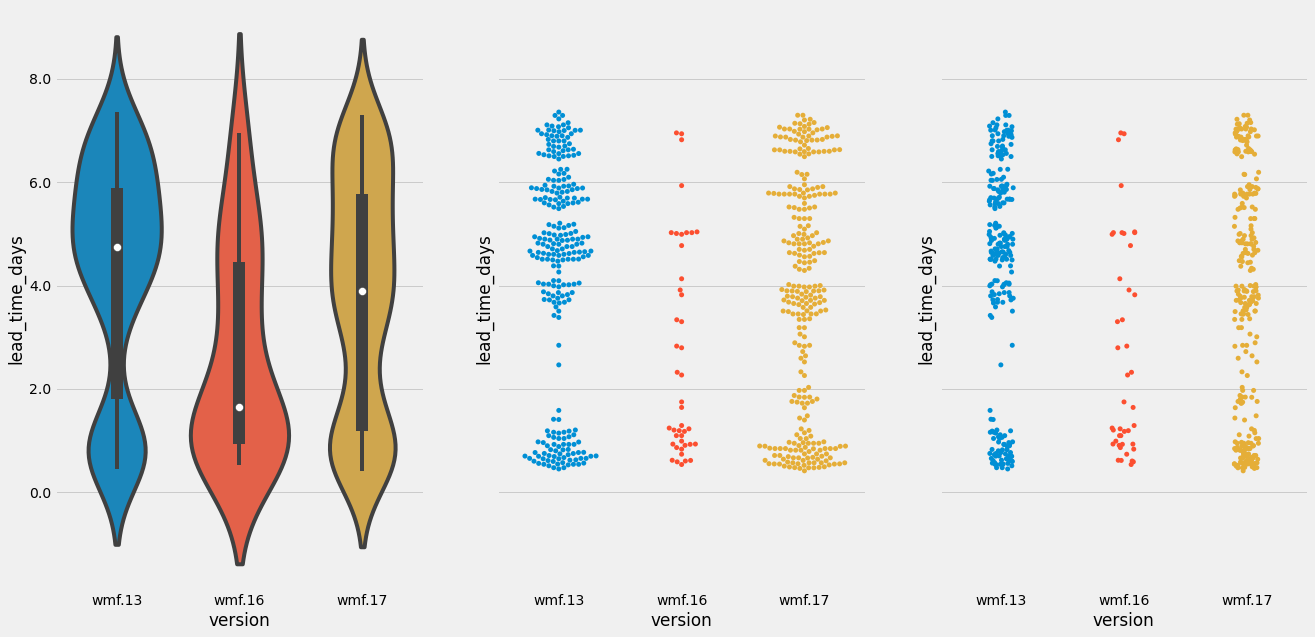

In [57]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))
sns.violinplot(data=cycle,x='version', y='lead_time_days', ax=ax[0])
sns.swarmplot(data=cycle,x='version', y='lead_time_days', ax=ax[1])
sns.stripplot(data=cycle,x='version', y='lead_time_days', ax=ax[2])
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.show()

### Cycle time

The time from patchset submission for code review to deploy

/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 71.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 18.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 69.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


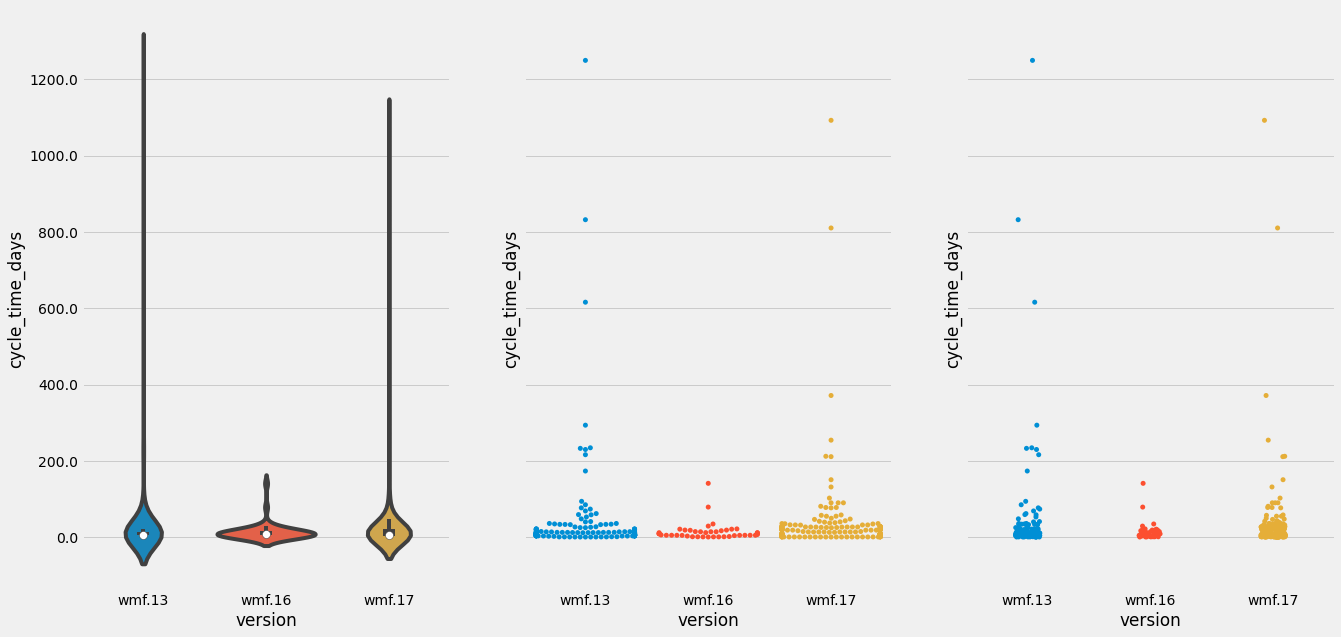

In [58]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))
sns.violinplot(data=cycle,x='version', y='cycle_time_days', ax=ax[0])
sns.swarmplot(data=cycle,x='version', y='cycle_time_days', ax=ax[1])
sns.stripplot(data=cycle,x='version', y='cycle_time_days', ax=ax[2])
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.show()

## Train bugfixes

> **Backport**
> * v. To retroactively supply a fix, or a new feature, to a previous version of a software product at the same time (or after) supplying it to the current version.
> * n. A commit that is backported

Each train has many backports. Each backport may be supplied to many trains. Backports add features, change feature flags, and fix bugs.

Some backports have tasks associated with them. Some tasks are "bugs" or "errors".

When a backport is associated with a task that is a "bug" or an "error" it's a bugfix. The number of bugfixes per train is a good signal of the number of bugs that were present in that train.

Bugs may persist for many trains; however, if a developer makes a backport, they felt that the bug was severe enough to warrant fixing immediately rather than waiting a week—that's signal about train quality, too.

In [59]:
train_bugs = pd.read_sql('''
select
  version,
  count(b.link) as bug_count
from
  train t
  join bug_train bt on bt.train_id = t.id
  join bug b on bt.bug_id = b.id
group by
  version
order by
  start_time
''', engine)
train_bugs.head()

,version,bug_count
0,1.27.0-wmf.16,3
1,1.27.0-wmf.19,1
2,1.27.0-wmf.21,1
3,1.27.0-wmf.22,2
4,1.27.0-wmf.23,3


### Bug count histogram

Seems to follow the power law

array([[<AxesSubplot:title={'center':'bug_count'}>]], dtype=object)

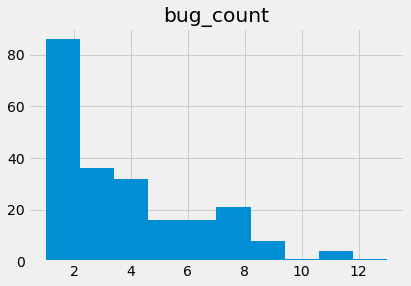

In [60]:
train_bugs.hist()

In [61]:
train_bugs.sort_values(by="bug_count", ascending=False).head()

,version,bug_count
120,1.34.0-wmf.13,13
119,1.34.0-wmf.11,11
206,1.37.0-wmf.20,11
90,1.32.0-wmf.24,11
194,1.37.0-wmf.5,11


In [62]:
train_bugs = pd.read_sql('''
select
  version,
  count(b.link) as bug_count,
  rollbacks,
  (select count(*) from blocker b where b.train_id = t.id and resolved = 1) as resolved_blockers,
      (select max(time_in_review) from patch p where p.train_id = t.id) as max_time_in_review,
    (select max(comments) from patch where patch.train_id = t.id) as max_comments_per_patch,
    (select max(start_time - created) from patch p where p.train_id = t.id) as max_cycle_time,
  patches
from
  train t
  join bug_train bt on bt.train_id = t.id
  join bug b on bt.bug_id = b.id
group by
  version
order by
  start_time
''', engine)
train_bugs.head()

,version,bug_count,rollbacks,resolved_blockers,max_time_in_review,max_comments_per_patch,max_cycle_time,patches
0,1.27.0-wmf.16,3,1,0,17557313.0,95.0,18128243.0,322
1,1.27.0-wmf.19,1,1,1,58248774.0,45.0,58798558.0,230
2,1.27.0-wmf.21,1,0,0,120956985.0,73.0,120937246.0,180
3,1.27.0-wmf.22,2,0,0,50045244.0,58.0,50160003.0,416
4,1.27.0-wmf.23,3,2,3,20153065.0,40.0,20228209.0,168


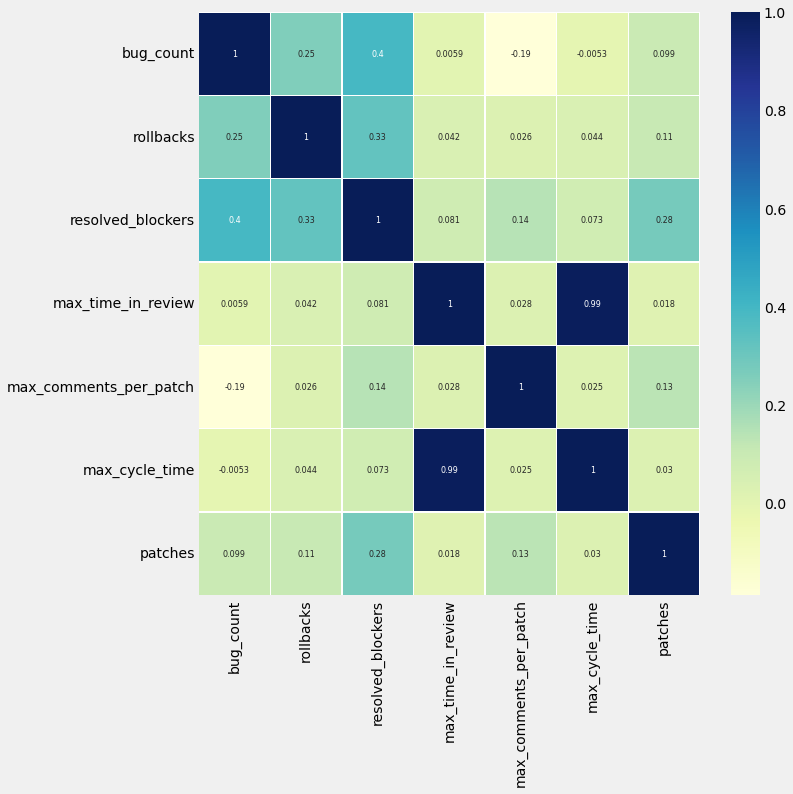

In [63]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(train_bugs.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [64]:
train_bugs[train_bugs['version'] == '1.38.0-wmf.17']

,version,bug_count,rollbacks,resolved_blockers,max_time_in_review,max_comments_per_patch,max_cycle_time,patches
220,1.38.0-wmf.17,5,5,3,93826976.0,31.0,94434309.0,284
